In [33]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

Define a new function which takes a data matrix of size $p \times n$ where $p$ is the number of random variables and $n$ is the number of data realizations and which takes a fixed target matrix as input parameters. The function returns the covariance matrix calculated using shrinkage estimation, the empirically estimated covariance matrix and the estimated shrinkage intensity.

The covariance matrix is given by $ \textbf{C} = \hat{\lambda}^* \textbf{T} + (1-\hat{\lambda}^*)\textbf{S} $, where $\hat{\lambda}^*$ is the estimated optimal shrinkage intensity, $\textbf{T}$ is the target matrix, and $\textbf{S}$ is the empirically estimated covariance matrix.

In [34]:
def shrinkage_cov_matrix(X, T):
    p, n = X.shape # Get shape of matrix
    
    x_mean = np.sum(X, axis=1)/n # Find mean of each row
    x_mean_M = np.tile(x_mean, (n, 1)).T # Repeat mean values as columns in a p x n matrix
    Y = X - x_mean_M
    
    W = []
    # Generate W array (which is 3D) of size (n, p, p), order of indices (k, i, j)
    for k in range(n):
        w = Y[:,k]
        W.append(np.outer(w, w))
    W_mean = np.sum(W, axis=0)/n
    
    # Emperically estimated covariance matrix
    S = n / (n-1) * W_mean
    
    W_mean_rep = np.tile(W_mean, (n, 1, 1))
    V = W - W_mean_rep
    # Compute variance of elements of the covariance matrix
    Var = n / (n-1)**3 * np.sum(V**2, axis=0)
    
    # Compute estimated shrinkage intensity parameter lambda
    lmbda_est = np.sum(Var) / np.sum((T-S)**2)
    
    # Compute shrinkage covariance matrix
    C_shrinkage = lmbda_est*T + (1-lmbda_est)*S
    
    return C_shrinkage, S, lmbda_est

In order to plot graphs of the mean squared error (MSE) against the number of data realizations, we create a new function which calculates the MSE as a function of $n$ for our toy example. We run a 100 simulations to find the average values.

In [38]:
def get_lmbda_MSE(n):
    # parameters
    p = 18 # nr of random variables
    mean = 0
    sigma = 1.1

    T = np.identity(p) # Target matrix
    C_true = sigma**2 * np.identity(p) # True covariance
    
    lmbdas_est = []
    MSE_MC_sum = 0
    MSE_MCS_sum = 0
    
    m = 100 # nr of realizations
    for _ in range(m):
        X = np.random.normal(mean, sigma, size=(p, n))
        
        C_shrinkage, S, lmbda_est = shrinkage_cov_matrix(X, T)
        
        MSE_MC = np.trace((S-C_true)@(S-C_true).T)
        MSE_MCS = np.trace((C_shrinkage-C_true)@(C_shrinkage-C_true).T)
        
        lmbdas_est.append(lmbda_est)
        MSE_MC_sum += MSE_MC
        MSE_MCS_sum += MSE_MCS

    lmbda_est = np.average(lmbdas_est)
    lmbda_est_se = np.std(lmbdas_est)
    MSE_MC = MSE_MC_sum / m
    MSE_MCS = MSE_MCS_sum / m
    MSE_T = np.trace((T-C_true)@(T-C_true).T)
    
    return lmbda_est, lmbda_est_se, MSE_MC, MSE_MCS, MSE_T

In [39]:
lmbda_est, lmbda_est_se, MSE_MC, MSE_MCS, MSE_T = get_lmbda_MSE(400)
print(f"Optimal value for shrinkage intensity: {lmbda_est}")
print(f"Standard deviation: {lmbda_est_se}")
print(f"MSE for MC: {MSE_MC}")
print(f"MSE for MC+S: {MSE_MCS}")
print(f"MSE for Target: {MSE_T}")

Optimal value for shrinkage intensity: 0.6153959297992213
Standard deviation: 0.05655166973150145
MSE for MC: 1.2563435500759943
MSE for MC+S: 0.4949196379244755
MSE for MC+S: 0.4949196379244755
MSE for Target: 0.7938000000000013


In [55]:
n = np.logspace(1, 4).astype(int)
print(n)

[   10    11    13    15    17    20    23    26    30    35    40    47
    54    62    71    82    95   109   126   145   167   193   222   255
   294   339   390   449   517   596   686   790   910  1048  1206  1389
  1599  1842  2120  2442  2811  3237  3727  4291  4941  5689  6551  7543
  8685 10000]


Text(0, 0.5, 'MSE')

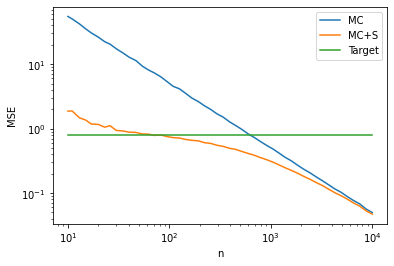

In [57]:
MSE_MC = []
MSE_MCS = []
MSE_T = []

for i in n:
    _, _, MSE_MC_val, MSE_MCS_val, MSE_T_val = get_lmbda_MSE(i)
    MSE_MC.append(MSE_MC_val)
    MSE_MCS.append(MSE_MCS_val)
    MSE_T.append(MSE_T_val)

plt.loglog(n, MSE_MC, label="MC")
plt.loglog(n, MSE_MCS, label="MC+S")
plt.loglog(n, MSE_T, label="Target")
plt.legend()
plt.xlabel("n")
plt.ylabel("MSE")